In [1]:
import fabio
from ipywidgets import interact
import PyMca5 as mca
from scipy.signal import fftconvolve
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'png'

Function that computes the pearson corr coeff for different correlation times:

In [42]:
def serial_corr(x, lag=1):
    N = len(x)
    f1 = x[lag:]
    f2 = x[:N-lag] # in reality I am just shifting the limits of the two functions, 
                   # whilst keeping the n of points the same
    corr = np.corrcoef(f1,f2)[0,1] # I want the diagonal of the matrix
    return corr
def autocorr(x):
    lags = list(range(len(x)//2))
    corrs = [serial_corr(x, lag) for lag in lags] # List comprehension!
    return corrs

Define directories for .edf and .spec files:

In [3]:
edfdir = '/data/id01/inhouse/leake/hc2615/id01/detector/align2/'
specdir = '/data/id01/inhouse/leake/hc2615/id01/spec/'
specfile = 'align2.spec'

Define a function to load .edf images and store them in a 3D array where the third dimension follows the images acquired within a scan (in this case it corresponds to *time*):

In [4]:
def load_edf(scan_numbers, specdir, edfdir, specfile):
    """
    Accepts a list of scans. Have a look in the spec file with PyMca to see what
    scans  you are interested into.
    """
    
    all_scans = dict()
    stack_total = dict()
    
    for scan_no in scan_numbers:
        # Load specfile
        sf = mca.specfilewrapper.Specfile(specdir+specfile)
        # Specify scan number and load it
        scan = sf[scan_no-1]
        # Store number of imgs referred to in specfile
        edf_num = scan.alllabels().index('mpx4inr')
        img_num = scan.data()[edf_num].shape[0]
        # Find the filename of the first edf file in the scan
        fname0 = scan.header('ULIMA')[0].split('/')[-1]
        # Load the first .edf file
        edf0 = fabio.open(edfdir + fname0)
        # Load the rest of the edf files, place them in an array
        scan_all = [edf0]
        for n in range(img_num-1):
            scan_all.append(scan_all[n].next())
        scan_all = np.array(scan_all)
        # Stack data so that each scan is a (512,512,img_num) 3D array
        for image in range(scan_all.shape[0]):
            scan_all[image] = scan_all[image].data
        scan_all = tuple(scan_all)
        stack = np.dstack(scan_all)+0.00001
        stack_total[scan_no] = stack
        
    return stack_total

In [60]:
scan_nos = [18,23,28,33,38,43]
scans = load_edf(scan_nos,specdir,edfdir,specfile)

In [64]:
# Select an ROI and visualise it
i1, i2 = 50, 150
j1, j2 = 50, 150
# Do the same for the Bragg
h1, h2 = 50, 150
k1, k2 = 380, 450

domain = {}
bragg = {}
for scan in scans:
    domain[scan] = scans[scan][i1:i2,j1:j2,0]
    bragg[scan] = scans[scan][h1:h2,k1:k2,0]

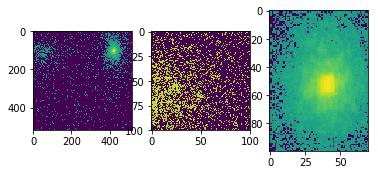

In [65]:
@interact(i=(list(range(18,48,5))))
def plotrois(i):
    pl.subplot(1,3,1)
    pl.imshow(np.log(scans[int(i)][:,:,0]))
    pl.subplot(1,3,2)
    pl.imshow(np.log(domain[int(i)]))
    pl.subplot(1,3,3)
    pl.imshow(np.log(bragg[int(i)]))

In [51]:
acfs = {}
for scan in scans:
    acf = np.array([])
    for row in range(i1,i2):
        for pixel in range(j1,j2):
            acf = np.append(acf,autocorr(scans[scan][row,pixel]))
    acfs[scan] = acf

/users/opid01/edo/venv/lib/python3.4/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/users/opid01/edo/venv/lib/python3.4/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [78]:
for scan in acfs:
    acfs[scan] = acfs[scan].reshape((i2-i1),(j2-j1),scans[scan].shape[2]//2)

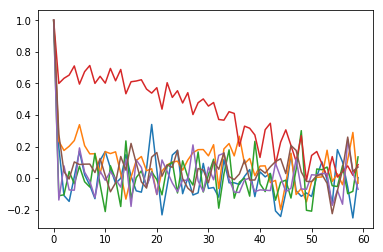

In [107]:
for scan in acfs:
    pl.plot(acfs[scan][30,30])

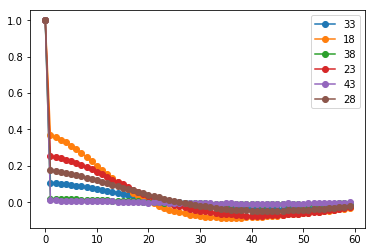

In [117]:
for scan in acfs:
    acfs[scan][np.isnan(acfs[scan])]=0
    pl.plot(acfs[scan].sum(axis=0).sum(axis=0)/(acfs[scan].shape[0]*acfs[scan].shape[1]),'-o',label=str(scan))
    pl.legend()
pl.show()

Still don't understand very well the overall shift in correlation.

In [46]:
def nacf(x):
    acf = fftconvolve(x,np.flipud(x),mode='same')
    N = len(acf)
    half_acf = acf[N//2:]
    lengths = np.arange(N, N//2, -1)
    half_acf /= lengths
    half_acf /= half_acf[0]
    
    return half_acf

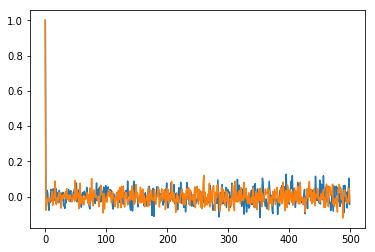

In [120]:
x = np.random.rand(1000)
y = np.random.randn(1000)
pl.plot(autocorr(x))
pl.plot(autocorr(y))

In [52]:
# pl.plot(x)
np.random.randn?